# Proje: Face Landmarks Detection ()

Snapchat'in yüzünüze göre inanılmaz filtreler uygulamayı nasıl başardığını hiç düşündünüz mü? Yüzünüzdeki bazı işaretleri algılayıp bu işaretlere göre bir filtre yansıtmak üzere programlanmıştır. Makine Öğrenmesinde bu işaretler Yüz İşaretleri olarak bilinir. Bu makalede Makine Öğrenmesi ile yüz İşaretlerini nasıl algılayabileceğinizi göstereceğiz.

Derin Öğrenme ile yüz işareti tespitini gerçekleştirmek için PyTorch kullanacağız.

In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## DLIB Veri Setini İndirme

Burada, farklı boyutlarda 6666'dan fazla görüntüden oluşan resmi bir DLIB veri kümesinde Yüz İşaretlerini tespit etmek için seçeceğim veri kümesi. Aşağıdaki kod, veri kümesini indirecek ve daha fazla araştırma için açacaktır.

In [2]:
import os

hedef_dizin = "data/face_landmarks"
os.makedirs(hedef_dizin, exist_ok=True)

if not os.path.exists(f'{hedef_dizin}/ibug_300W_large_face_landmark_dataset'):
    !curl -o {hedef_dizin}/ibug_300W_large_face_landmark_dataset.tar.gz http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf '{hedef_dizin}/ibug_300W_large_face_landmark_dataset.tar.gz' -C {hedef_dizin}
    !rm -r '{hedef_dizin}/ibug_300W_large_face_landmark_dataset.tar.gz'


Görüntülenen çıkış son 5000 satıra kısaltıldı.
ibug_300W_large_face_landmark_dataset/helen/trainset/280470418_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2896253715_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2777541034_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2540799498_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2966782955_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/1421150832_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2267947745_1.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2599011432_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2652792032_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2880878213_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2826061016_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2234753986_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2233368704_2.jpg
ibug_300W

## Veri Setini Görselleştirin

Üzerinde çalıştığımız şeye bir bakalım, geçmemiz gereken tüm veri temizleme ve ön işleme fırsatlarını görelim. İşte bu görev için aldığımız veri setinden bir görüntü örneği:

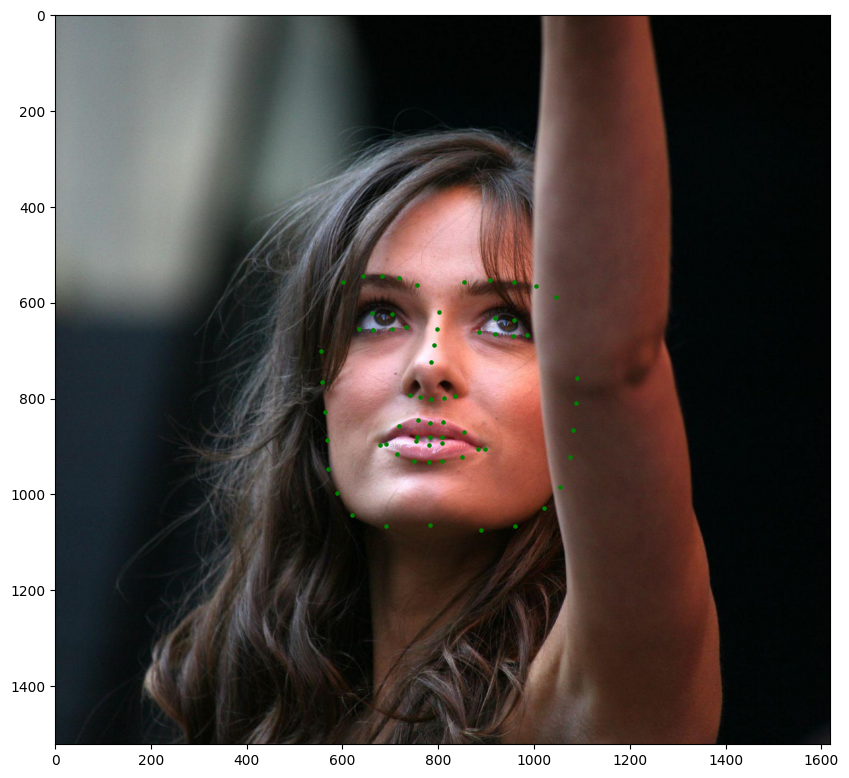

In [3]:
file = open('data/face_landmarks/ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts', 'r', encoding='utf-8')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('data/face_landmarks/ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

Yüzün görüntüde çok az yer kapladığını görebilirsiniz. Bu görüntüyü sinir ağında kullanırsak arka planı da alacaktır. Yani bir metin verisi hazırladığımız gibi bu görüntü veri setini daha fazla araştırma için hazırlayacağız.

## Veri Kümesi Sınıfları Oluşturma

labels_ibug_300W_train.xml, giriş resimleri ve yüzleri kırpmak için sınırlayıcı kutu ve işaretlerden oluşur. Tüm bu değerleri eğitim süreci sırasında kolayca erişebilmemiz için listede saklayacağız.

In [4]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

Train Dönüşümlerini Görselleştirme


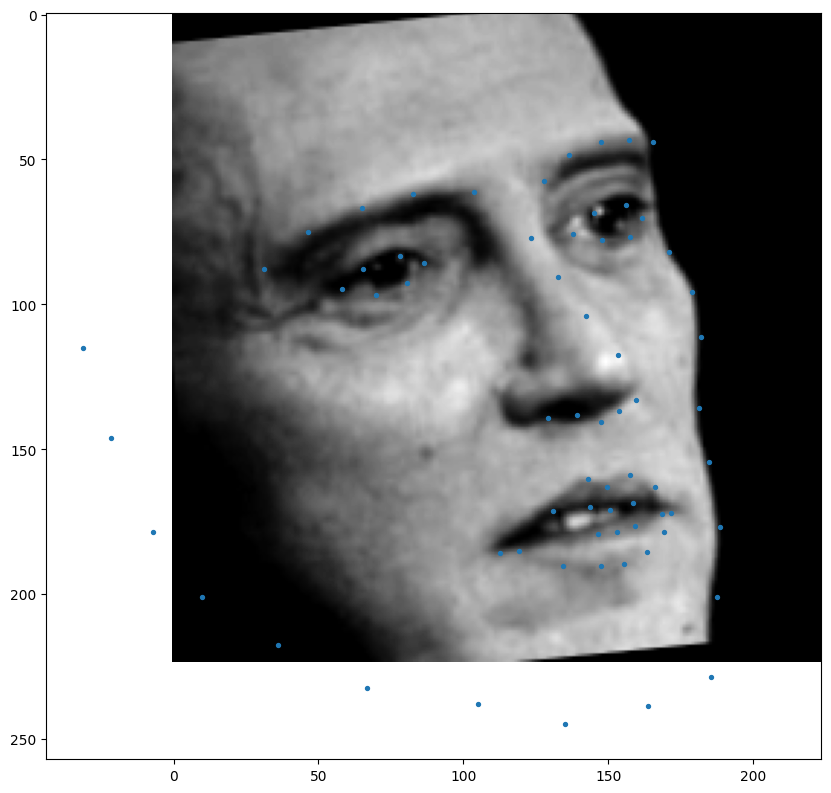

In [5]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import os

class FaceLandmarksDataset(Dataset):
    def __init__(self, transform=None):
        tree = ET.parse('data/face_landmarks/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'data/face_landmarks/ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5
        return image, landmarks

# Veri setini oluştur
dataset = FaceLandmarksDataset(Transforms())

# İlk örneği al ve görselleştir
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224

plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.scatter(landmarks[:,0], landmarks[:,1], s=8)
plt.show()


## Yüz Yer İşaretlerinin Eğitimi ve Tahmini için Veri Kümesini Bölmek

In [6]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Giriş verilerinin şeklinin test edilmesi

## Yüz İşaretleri Algılama Modelini Tanımlama

In [7]:
from tqdm import tqdm

# Tüm batch'ler üzerinde ilerleme çubuğuyla döngü
for batch_idx, (images, landmarks) in enumerate(tqdm(train_loader, desc='İşleniyor')):
    print(f'Batch {batch_idx + 1}:')
    print(f'Images shape: {images.shape}')
    print(f'Landmarks shape: {landmarks.shape}')

İşleniyor:   4%|▍         | 4/94 [00:02<00:41,  2.19it/s]

Batch 1:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 2:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 3:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 4:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 5:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:   6%|▋         | 6/94 [00:04<01:13,  1.20it/s]

Batch 6:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 7:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 8:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  10%|▉         | 9/94 [00:06<00:51,  1.66it/s]

Batch 9:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  11%|█         | 10/94 [00:06<00:53,  1.58it/s]

Batch 10:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 11:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 12:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  14%|█▍        | 13/94 [00:08<00:46,  1.74it/s]

Batch 13:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  15%|█▍        | 14/94 [00:09<00:48,  1.64it/s]

Batch 14:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 15:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 16:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  18%|█▊        | 17/94 [00:10<00:40,  1.90it/s]

Batch 17:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  19%|█▉        | 18/94 [00:11<00:49,  1.53it/s]

Batch 18:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 19:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 20:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  22%|██▏       | 21/94 [00:13<00:49,  1.46it/s]

Batch 21:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  23%|██▎       | 22/94 [00:15<00:55,  1.30it/s]

Batch 22:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 23:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 24:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  27%|██▋       | 25/94 [00:16<00:43,  1.59it/s]

Batch 25:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  28%|██▊       | 26/94 [00:16<00:39,  1.70it/s]

Batch 26:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 27:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 28:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  32%|███▏      | 30/94 [00:18<00:34,  1.87it/s]

Batch 29:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 30:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 31:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 32:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  35%|███▌      | 33/94 [00:20<00:35,  1.70it/s]

Batch 33:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  36%|███▌      | 34/94 [00:22<00:44,  1.35it/s]

Batch 34:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 35:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 36:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  39%|███▉      | 37/94 [00:24<00:38,  1.47it/s]

Batch 37:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  40%|████      | 38/94 [00:25<00:43,  1.30it/s]

Batch 38:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 39:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 40:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  44%|████▎     | 41/94 [00:26<00:34,  1.53it/s]

Batch 41:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  45%|████▍     | 42/94 [00:28<00:40,  1.29it/s]

Batch 42:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 43:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 44:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  48%|████▊     | 45/94 [00:29<00:32,  1.53it/s]

Batch 45:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  49%|████▉     | 46/94 [00:30<00:32,  1.47it/s]

Batch 46:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 47:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 48:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  52%|█████▏    | 49/94 [00:32<00:29,  1.53it/s]

Batch 49:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 50:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 51:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 52:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  56%|█████▋    | 53/94 [00:33<00:22,  1.79it/s]

Batch 53:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  57%|█████▋    | 54/94 [00:34<00:22,  1.77it/s]

Batch 54:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 55:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 56:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  61%|██████    | 57/94 [00:35<00:19,  1.90it/s]

Batch 57:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  62%|██████▏   | 58/94 [00:36<00:21,  1.71it/s]

Batch 58:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 59:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 60:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  65%|██████▍   | 61/94 [00:38<00:17,  1.87it/s]

Batch 61:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  66%|██████▌   | 62/94 [00:38<00:17,  1.82it/s]

Batch 62:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 63:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 64:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  69%|██████▉   | 65/94 [00:41<00:19,  1.46it/s]

Batch 65:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  70%|███████   | 66/94 [00:41<00:17,  1.63it/s]

Batch 66:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 67:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 68:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  73%|███████▎  | 69/94 [00:43<00:16,  1.54it/s]

Batch 69:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  74%|███████▍  | 70/94 [00:44<00:14,  1.68it/s]

Batch 70:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 71:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 72:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  78%|███████▊  | 73/94 [00:46<00:12,  1.62it/s]

Batch 73:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  79%|███████▊  | 74/94 [00:46<00:11,  1.79it/s]

Batch 74:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 75:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 76:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  82%|████████▏ | 77/94 [00:48<00:09,  1.74it/s]

Batch 77:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 78:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 79:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 80:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  86%|████████▌ | 81/94 [00:49<00:06,  1.95it/s]

Batch 81:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  87%|████████▋ | 82/94 [00:50<00:06,  1.82it/s]

Batch 82:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 83:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 84:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  90%|█████████ | 85/94 [00:51<00:04,  1.99it/s]

Batch 85:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  91%|█████████▏| 86/94 [00:52<00:04,  1.90it/s]

Batch 86:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 87:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 88:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  95%|█████████▍| 89/94 [00:54<00:02,  1.84it/s]

Batch 89:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor:  96%|█████████▌| 90/94 [00:54<00:01,  2.02it/s]

Batch 90:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 91:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 92:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])


İşleniyor: 100%|██████████| 94/94 [00:56<00:00,  1.67it/s]

Batch 93:
Images shape: torch.Size([64, 1, 224, 224])
Landmarks shape: torch.Size([64, 68, 2])
Batch 94:
Images shape: torch.Size([48, 1, 224, 224])
Landmarks shape: torch.Size([48, 68, 2])


Şimdi temel çerçevemiz olarak ResNet18'i kullanacağız. İlk ve son katmanları, katmanların amacımıza kolayca uyması için değiştireceğiz.

In [8]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

**Yardımcı Fonksiyonlar**

In [9]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

## Yüz Yer İşaretlerinin Tespiti için Sinir Ağının Eğitimi

Şimdi gerçek ve tahmin edilen yüz işaretleri arasındaki (Mean Squared Error) Ortalama Karesel Hata'yı kullanacağız

In [10]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in range(1,num_epochs+1):

    loss_train = 0
    loss_valid = 0
    running_loss = 0

    network.train()
    for step in range(1,len(train_loader)+1):

        images, landmarks = next(iter(train_loader))

        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda()

        predictions = network(images)

        # clear all the gradients before calculating them
        optimizer.zero_grad()
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        print_overwrite(step, len(train_loader), running_loss, 'train')

    network.eval()
    with torch.no_grad():

        for step in range(1,len(valid_loader)+1):

            images, landmarks = next(iter(valid_loader))

            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()

            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth')
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 84/84  Loss: 0.0059 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0231  Valid Loss: 0.0059
--------------------------------------------------

Minimum Validation Loss of 0.0059 at epoch 1/10
Model Saved

Valid Steps: 84/84  Loss: 0.0051 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0056  Valid Loss: 0.0051
--------------------------------------------------

Minimum Validation Loss of 0.0051 at epoch 2/10
Model Saved

Valid Steps: 84/84  Loss: 0.0042 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0049  Valid Loss: 0.0042
--------------------------------------------------

Minimum Validation Loss of 0.0042 at epoch 3/10
Model Saved

Valid Steps: 84/84  Loss: 0.0036 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0039  Valid Loss: 0.0036
--------------------------------------------------

Minimum Validation Loss of 0.0036 at epoch 4/10
Model Saved

Valid Steps:

## Yüz Yer İşaretleri Tahmini

Şimdi yukarıda eğittiğimiz modeli veri setindeki görünmeyen görüntüler üzerinde kullanıyoruz.

<ipython-input-11-2a3b4d0719fb>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_network.load_state_dict(torch.load('/content/face_landmarks.pth'))


Total number of test images: 666
Elapsed Time : 1.5296449661254883


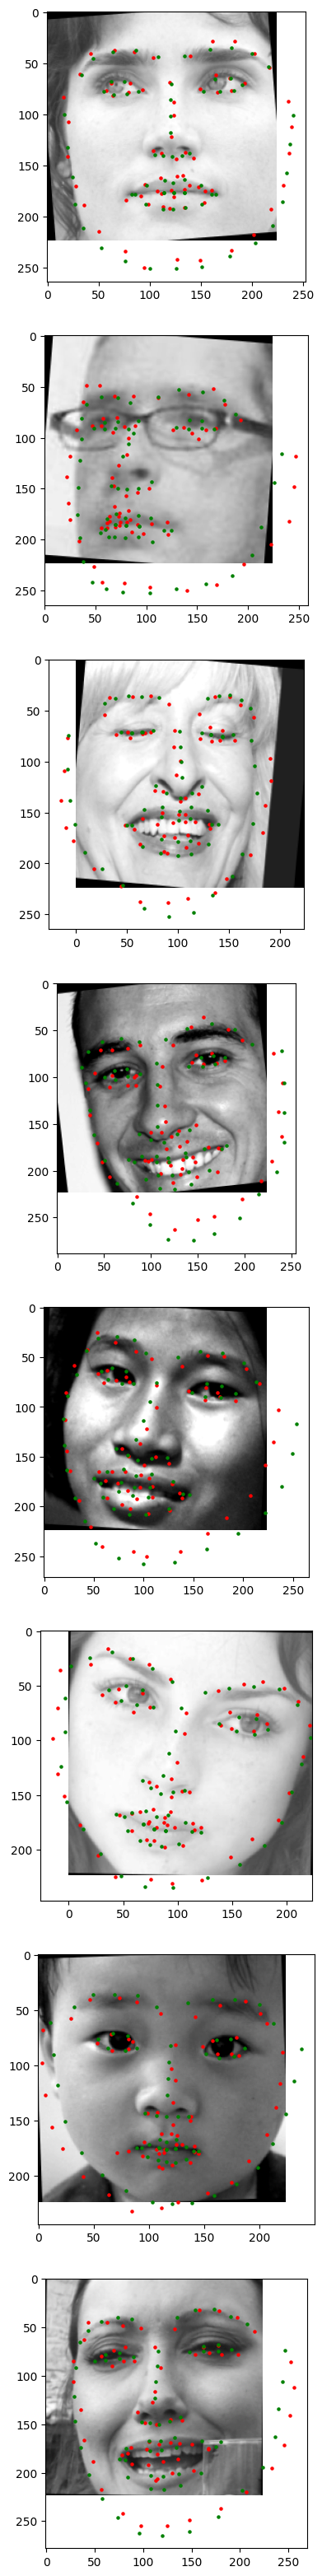

In [11]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth'))
    best_network.eval()

    images, landmarks = next(iter(valid_loader))

    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)

    plt.figure(figsize=(10,40))

    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time))

## Sonuç:


Proje, derin öğrenme kullanarak yüz yer işaretlerinin tespitini araştırdı. ResNet18 modeli, yüz yer işaretlerini doğru bir şekilde tahmin etmek için eğitildi. Eğitim ve doğrulama kayıplarının izlenmesi, model performansının değerlendirilmesine izin verdi. Sonuçlar, derin öğrenmenin yüz yer işaretlerinin tespiti için etkili bir yaklaşım olduğunu göstermektedir. Ancak, performansı daha da artırmak için daha büyük veri kümeleri ve daha gelişmiş mimariler kullanılabilir. Ayrıca, modelin doğruluğu ve verimliliği, kayıp fonksiyonları ve optimizasyon algoritmaları gibi farklı parametreler ve teknikler kullanılarak optimize edilebilir. Genel olarak, derin öğrenme tabanlı yüz yer işaretlerinin tespiti, çeşitli uygulamalar için umut vaat eden bir çözüm sunmaktadır.

Daha fazla geliştirme için, mobil cihazlara dağıtım için modelin boyutu ve hesaplama karmaşıklığı azaltılabilir. Ayrıca, ışıklandırma, poz ve tıkanıklık gibi değişikliklere karşı daha sağlam hale getirmek için model eğitilebilir. Ek olarak, yüz ifadesi tanıma veya yüz kimlik doğrulama gibi diğer görevlerle birleştirilebilir. Projenin sonuçları, yüz yer işaretlerinin tespiti için derin öğrenmenin uygulanabilirliğini ve gelecekteki araştırmalar için değerli bilgiler sağladığını göstermektedir.

